In [81]:
import pandas as pd
import numpy as np
import copy
from collections import deque
from pandas.core.frame import DataFrame
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [82]:
mu, sigma = 10, 3
s1 = st.norm(mu, sigma).rvs(1000000)
s2 = st.norm(mu-6, sigma+6).rvs(100000)

df_1 = pd.DataFrame(s1,columns=["feat"]  )
df_1['Y'] = 0
df_2 = pd.DataFrame(s2,columns=["feat"]  )
df_2['Y'] = 1

df = pd.concat([df_1,df_2],axis=0).reset_index(drop=True)
df.head(5)

,feat,Y
0,8.435267,0
1,6.488951,0
2,7.746525,0
3,10.036076,0
4,3.916366,0


In [83]:
feature_cols = [col for col in df.columns if col != 'Y']
target_cols = [col for col in df.columns if col not in feature_cols]

<Figure size 432x288 with 0 Axes>

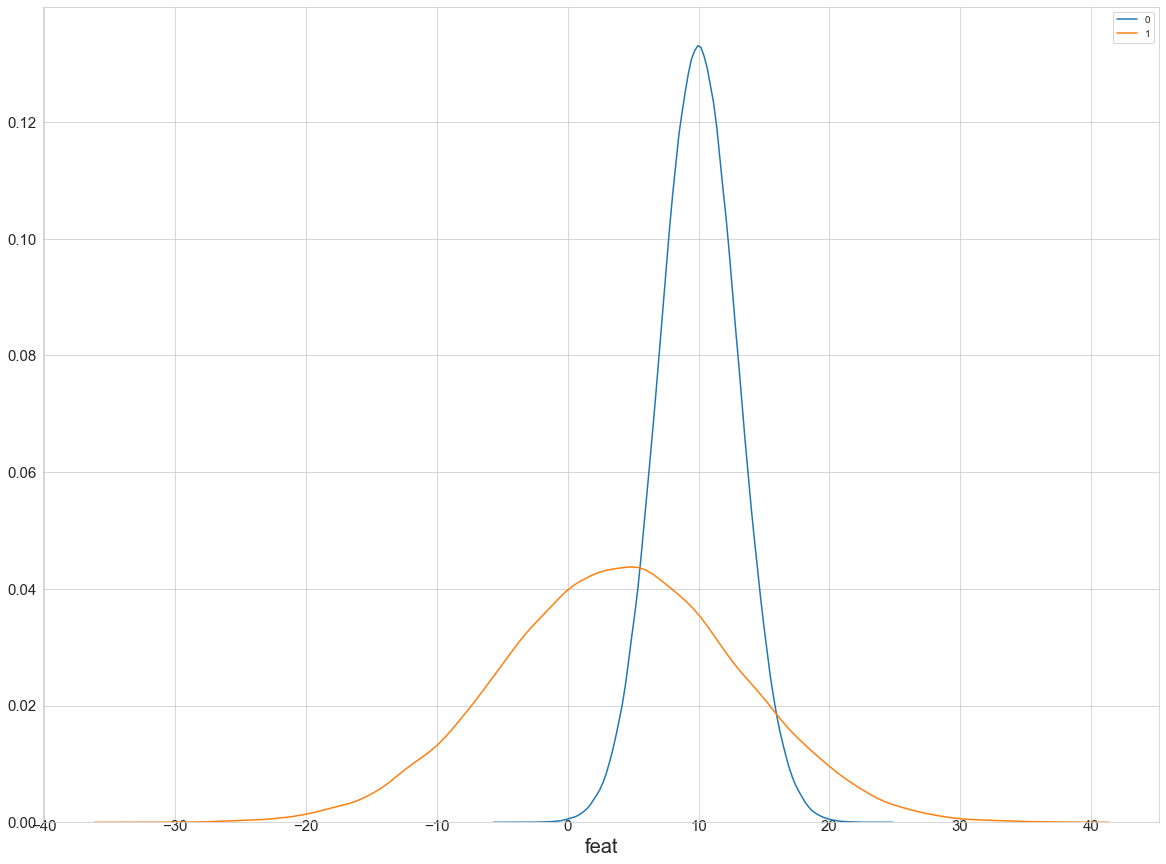

In [84]:
def plot_feature_distribution(df1, df2, label1, label2, features,plot_rows,plot_cols):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(20,15))

    for feature in features:
        i += 1
        plt.subplot(plot_rows,plot_cols,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=20)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=15, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=15)
    plt.show();

t0 = df.loc[df['Y'] == 0]
t1 = df.loc[df['Y'] == 1]
#features = df.columns.values[0]
plot_feature_distribution(t0, t1, '0', '1', feature_cols,1,1)

### PDF Method

* Input一個Feat & Label, 得到各點P(Y=1) - P(Y=0)的機率
* 若該值是正,代表該值域下1的樣本點比0多

In [85]:
def PDF_func(dataframe,feature,start,end,step,FileName):
    #initial
    N = len(dataframe[feature])
    seq = dataframe[feature].sort_values().reset_index(drop=True)
    pdf_range = range(start,end,step)
    
    tmp_pdframe = pd.DataFrame(
            [sum((pdf_range[i-1]<seq ) & (seq<pdf_range[i]))/N for i in range(1,len(pdf_range))]
            ,columns=['pdf'])
    #N個數有N-1個區間
    #區間長度:Index~Index+step
    tmp_pdframe.index = pdf_range[:-1]
    globals()['pdf_frame_'+str(FileName)] = tmp_pdframe
    print("Done!File Name: pdf_frame_"+ str(FileName))

In [86]:
PDF_func(df[df['Y']==1],'feat',int(min(df['feat'])),int(max(df['feat'])),1,'feat_1')
PDF_func(df[df['Y']==0],'feat',int(min(df['feat'])),int(max(df['feat'])),1,'feat_0')

Done!File Name: pdf_frame_feat_1
Done!File Name: pdf_frame_feat_0


In [87]:
pdf_frame_feat_1.head(10)

,pdf
-33,0.00002
-32,0.00002
-31,0.00002
-30,0.00004
-29,0.00002
-28,0.00005
-27,0.00020
-26,0.00027
-25,0.00039
-24,0.00035


In [88]:
pdf_frame_feat_0.head(10)

,pdf
-33,0.0
-32,0.0
-31,0.0
-30,0.0
-29,0.0
-28,0.0
-27,0.0
-26,0.0
-25,0.0
-24,0.0


In [89]:
pdf_diff = pdf_frame_feat_1-pdf_frame_feat_0

In [90]:
pdf_diff.head(20)

,pdf
-33,0.00002
-32,0.00002
-31,0.00002
-30,0.00004
-29,0.00002
-28,0.00005
-27,0.00020
-26,0.00027
-25,0.00039
-24,0.00035


In [91]:
df['pdf_diff_feat']=pdf_diff.loc[round(df['feat'])].reset_index(drop=True)
#偶爾會有NA值

C:\Users\w9012219\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


### Try On XGB

* XGB本質迭代是切分值域,切分後值域會漸漸縮小 -> 隱含yi只能被值域鄰近的樣本來預測
* 同棵樹內:值域變小 / 不同棵樹:繼續grouping
* X分配只有偏斜一邊->leaf / X分配偏斜一邊以上->level

Type 1: without pdf_diff_feat..

In [92]:
import xgboost as xgb
param = {'max_depth': 8,
         'learning_rate ': 0.01,
         'silent': 1,
         'objective': 'binary:logistic',
         "eval_metric":"auc"
         #"scale_pos_weight":10,
         #"subsample":0.9,
         #"min_child_weight":5,
          }

x_col=['feat']
train_X = df[x_col]

y_col=['Y']
train_Y = df[y_col]

dtrain = xgb.DMatrix(train_X,label=train_Y)

cv_res= xgb.cv(param,
               dtrain,
               num_boost_round=1000,#830
               early_stopping_rounds=10,
               nfold=2, metrics='logloss',show_stdv=True)

print(cv_res)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.484788           0.000029           0.485039          0.000054
1             0.371873           0.000177           0.372331          0.000024
2             0.303295           0.000068           0.303932          0.000132
3             0.259702           0.000166           0.260507          0.000082
4             0.231898           0.000177           0.232871          0.000133
5             0.213573           0.000190           0.214720          0.000167
6             0.201881           0.000330           0.203180          0.000091
7             0.194334           0.000284           0.195805          0.000177
8             0.189639           0.000358           0.191265          0.000143
9             0.186744           0.000376           0.188524          0.000147
10            0.184950           0.000343           0.186889          0.000199
11            0.183879           0.000350           

In [93]:
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
bst.get_score(importance_type='gain')

{'feat': 154.68681478158817}

Type 2: add pdf_diff_feat!

In [94]:
x_col=['feat','pdf_diff_feat']
train_X = df[x_col]

y_col=['Y']
train_Y = df[y_col]

dtrain = xgb.DMatrix(train_X,label=train_Y)

cv_res= xgb.cv(param,
               dtrain,
               num_boost_round=1000,#830
               early_stopping_rounds=10,
               nfold=2, metrics='logloss',show_stdv=True)

print(cv_res)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.484768           0.000058           0.485004          0.000031
1             0.371773           0.000087           0.372205          0.000049
2             0.303497           0.000122           0.304089          0.000075
3             0.259903           0.000172           0.260661          0.000074
4             0.231777           0.000160           0.232699          0.000152
5             0.213633           0.000331           0.214685          0.000023
6             0.201931           0.000268           0.203128          0.000122
7             0.194469           0.000239           0.195845          0.000187
8             0.189714           0.000261           0.191240          0.000213
9             0.186781           0.000325           0.188472          0.000195
10            0.185014           0.000357           0.186872          0.000192
11            0.183899           0.000329           

In [95]:
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
bst.get_score(importance_type='gain')

{'feat': 155.3056384310059, 'pdf_diff_feat': 1773.0308585954765}

Type 3.1: X scaling matters (>1)

In [96]:
#跟尺度也有關係
df['feat_1.5'] = df['feat']*1.5
PDF_func(df[df['Y']==1],'feat_1.5',int(min(df['feat_1.5'])-2),int(max(df['feat_1.5'])+2),1,'feat_1')
PDF_func(df[df['Y']==0],'feat_1.5',int(min(df['feat_1.5'])-2),int(max(df['feat_1.5'])+2),1,'feat_0')

Done!File Name: pdf_frame_feat_1
Done!File Name: pdf_frame_feat_0


In [97]:
pdf_diff = pdf_frame_feat_1-pdf_frame_feat_0
max(pdf_diff['pdf'])

0.026742

In [98]:
#Create Feature
df['pdf_diff_feat']=pdf_diff.loc[round(df['feat_1.5'])].reset_index(drop=True)

C:\Users\w9012219\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [99]:
x_col=['feat','pdf_diff_feat']
train_X = df[x_col]

y_col=['Y']
train_Y = df[y_col]

dtrain = xgb.DMatrix(train_X,label=train_Y)

cv_res= xgb.cv(param,
               dtrain,
               num_boost_round=1000,#830
               early_stopping_rounds=10,
               nfold=2, metrics='logloss',show_stdv=True)

print(cv_res)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.484973           0.000209           0.485193          0.000134
1             0.371899           0.000143           0.372321          0.000008
2             0.303561           0.000140           0.304136          0.000038
3             0.259957           0.000130           0.260705          0.000103
4             0.231779           0.000228           0.232695          0.000060
5             0.213740           0.000210           0.214805          0.000126
6             0.201882           0.000204           0.203097          0.000153
7             0.194444           0.000242           0.195833          0.000147
8             0.189741           0.000250           0.191277          0.000165
9             0.186806           0.000299           0.188497          0.000161
10            0.185021           0.000288           0.186862          0.000207
11            0.183942           0.000285           

In [100]:
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
bst.get_score(importance_type='gain')

{'feat': 133.87454868691623, 'pdf_diff_feat': 1802.9261227402274}

Type 3.2: X scaling matters (<1)

In [101]:
#跟尺度也有關係
df['feat_0.75'] = df['feat']*0.75
PDF_func(df[df['Y']==1],'feat_0.75',int(min(df['feat_0.75'])-2),int(max(df['feat_0.75'])+2),1,'feat_1')
PDF_func(df[df['Y']==0],'feat_0.75',int(min(df['feat_0.75'])-2),int(max(df['feat_0.75'])+2),1,'feat_0')

Done!File Name: pdf_frame_feat_1
Done!File Name: pdf_frame_feat_0


In [102]:
pdf_diff = pdf_frame_feat_1-pdf_frame_feat_0
max(pdf_diff['pdf'])

0.053441

In [103]:
#Create Feature
df['pdf_diff_feat']=pdf_diff.loc[round(df['feat_0.75'])].reset_index(drop=True)

C:\Users\w9012219\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [104]:
x_col=['feat','pdf_diff_feat']
train_X = df[x_col]

y_col=['Y']
train_Y = df[y_col]

dtrain = xgb.DMatrix(train_X,label=train_Y)

cv_res= xgb.cv(param,
               dtrain,
               num_boost_round=1000,#830
               early_stopping_rounds=10,
               nfold=2, metrics='logloss',show_stdv=True)

print(cv_res)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.484922           0.000148           0.485158          0.000061
1             0.371968           0.000076           0.372398          0.000066
2             0.303546           0.000099           0.304134          0.000106
3             0.259968           0.000152           0.260715          0.000122
4             0.231768           0.000128           0.232693          0.000203
5             0.213618           0.000325           0.214685          0.000043
6             0.201917           0.000200           0.203119          0.000205
7             0.194468           0.000286           0.195829          0.000163
8             0.189767           0.000330           0.191305          0.000153
9             0.186790           0.000268           0.188492          0.000221
10            0.185042           0.000315           0.186896          0.000214
11            0.183899           0.000285           

In [105]:
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
bst.get_score(importance_type='gain')

{'feat': 144.14994834313356, 'pdf_diff_feat': 1816.0713253709994}

### Visulization

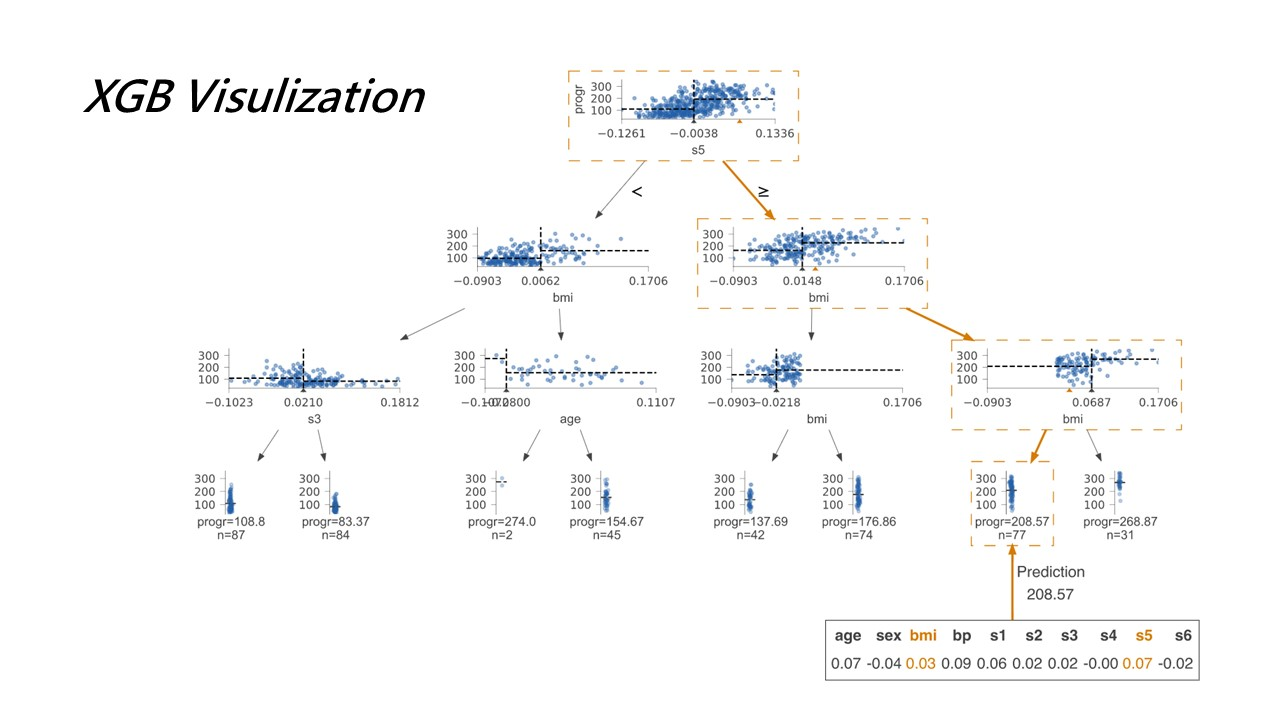

In [75]:
from IPython.display import Image
Image("XGB visulization.jpg")